In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from random import shuffle

In [11]:
train_dir = 'C:/Users/Abhishek Singh/ML_scripts/Dogs vs cats/train'
test_dir = 'C:/Users/Abhishek Singh/ML_scripts/Dogs vs cats/test'
IMG_SIZE = 100
LR = 1e-3

MODEL_NAME = 'cats_vs_dogs.{}.{}'.format(LR, '7conv-layers')

In [3]:
def label_img(img):
    word_label = img.split('.')[0]
    if word_label == 'cat': return[1, 0]
    elif word_label == 'dog': return [0, 1]
    

In [4]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(train_dir)):
        label = label_img(img)
        path = os.path.join(train_dir, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data
    

In [5]:
def process_test_data():
    test_data = []
    for img in tqdm(os.listdir(test_dir)):
        path = os.path.join(test_dir, img)
        img_num = img.split('.')[0]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        test_data.append([np.array(img), img_num])
        
    shuffle(test_data)
    np.save('test_data.npy', test_data)
    return test_data
        

In [6]:
train_data = create_train_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [02:50<00:00, 146.53it/s]


In [7]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


In [8]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)


Training Step: 3829  | total loss: 0.17012 | time: 427.985s
| Adam | epoch: 010 | loss: 0.17012 - acc: 0.9303 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.17146 | time: 433.027s
| Adam | epoch: 010 | loss: 0.17146 - acc: 0.9279 | val_loss: 0.41709 - val_acc: 0.8480 -- iter: 24500/24500
--


In [12]:
model.save(MODEL_NAME)

INFO:tensorflow:C:\Users\Abhishek Singh\ML_scripts\Dogs vs cats\cats_vs_dogs.0.001.7conv-layers is not in all_model_checkpoint_paths. Manually adding it.


100%|████████████████████████████████████████████████████████████████████████████| 12500/12500 [02:45<00:00, 75.33it/s]


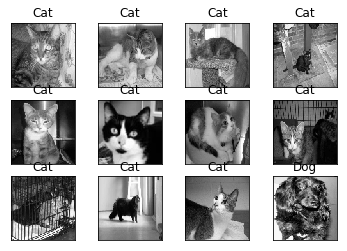

In [13]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='Dog'
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [14]:
with open('submission_file.csv','w') as f:
    f.write('id,label\n')

In [15]:
with open('submission_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:20<00:00, 154.85it/s]
